# Algoritmo 2 - Clustering

## Introdução
Exploramos atributos técnicos e físicos de jogadores/as do EA FC 24 para identificar padrões de semelhança com `KMeans`.
A análise foca em atletas de campo e procura responder: quantos segmentos coerentes existem, que características definem cada grupo e como género/posição se distribuem entre eles.

## Objetivo do notebook
Este caderno consolida o pipeline de clustering aplicado aos jogadores do FC 24.
Inclui preparação do ambiente, ingestão e limpeza dos dados, seleção de atributos, avaliação de `k` e análise qualitativa dos clusters com apoio de PCA, tabelas e visualizações.

### Preparação do ambiente
Instala as dependências necessárias diretamente no kernel para garantir versões alinhadas para `numpy`, `pandas`, `matplotlib` e `mlxtend`.

In [1]:
print("Hello World!")

%pip install --upgrade pip
%pip install numpy
%pip install matplotlib
%pip install pandas
%pip install mlxtend

Hello World!
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 1.8/1.8 MB 13.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.2
    Uninstalling pip-24.2:
      Successfully uninstalled pip-24.2
Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   ---------- ----------------------------- 3.4/12.8 MB 20.2 MB/s eta 0:00:01
   ---------------------------------------- 12.8/12.8 MB 34.8 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -------------- ------------------------- 2.9/8.1 MB 16.8 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 25.2 MB/s  0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 66.2

### Carregamento e consolidação dos dados
Lemos os ficheiros femininos e masculinos do EA FC, adicionamos o campo `gender` e criamos um `DataFrame` único filtrado para a versão 24 do jogo.

In [4]:
import pandas as pd



male_players = pd.read_csv("Data/EA_FC/male_players.csv",low_memory=False)
female_players = pd.read_csv("Data/EA_FC/female_players.csv")

male_players["gender"] = "M"
female_players["gender"] = "F"

players = pd.concat([male_players, female_players], ignore_index=True)

# Ficar só com FC 24
players24 = players[players["fifa_version"] == 24].copy()




### Agrupamento de posições e filtro de jogadores
Convertimos `player_positions` em grupos agregados (GK/DEF/MID/ATT) e mantemos apenas defesas, médios e avançados para estudar perfis de atletas de campo.

In [10]:
def map_position_group(positions_str: str) -> str:
    if pd.isna(positions_str):
        return "OTHER"
    main_pos = positions_str.split(",")[0].strip()
    defenders = {"CB", "LB", "RB", "LWB", "RWB"}
    mids = {"CDM", "CM", "CAM", "LM", "RM"}
    attackers = {"ST", "CF", "LW", "RW"}

    if main_pos == "GK":
        return "GK"
    elif main_pos in defenders:
        return "DEF"
    elif main_pos in mids:
        return "MID"
    elif main_pos in attackers:
        return "ATT"
    else:
        return "OTHER"

players24["position_group"] = players24["player_positions"].apply(map_position_group)


## Isto remove jogadores que nao estejam no campo (tipo suplentes, ou guarda-redes)
Players24InField = players24[players24["position_group"].isin(["DEF", "MID", "ATT"])].copy()




### Seleção de atributos e normalização
Definimos as métricas técnico-físicas que alimentam o clustering, removemos linhas com `NaN` e aplicamos `StandardScaler` para colocar todas as escalas no mesmo patamar.

In [11]:


feature_cols = [
    "pace", "shooting", "passing", "dribbling",
    "defending", "physic",
    "height_cm", "weight_kg", "age",
    "skill_ball_control", "skill_long_passing",
    "movement_acceleration", "movement_sprint_speed",
    "movement_agility", "movement_balance",
    "power_strength", "power_stamina"
]




# tirar linhas com NaN nessas colunas
cluster = Players24InField.dropna(subset=feature_cols).copy()

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = cluster[feature_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)




### Escolha de k e criação dos clusters
Testamos valores de `k` entre 3 e 7 guardando inércia e *silhouette* para suporte analítico e aplicamos o `KMeans` final (k=4) antes de gerar estatísticas e distribuições por género.

In [12]:
from sklearn.metrics import silhouette_score

inertias = []
silhouettes = []

for k in range(3, 8):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))


best_k = 4  # exemplo
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
cluster["cluster"] = kmeans.fit_predict(X_scaled)


cluster_stats = cluster.groupby("cluster")[feature_cols].mean()

gender_counts = cluster.groupby(["cluster", "gender"]).size().unstack(fill_value=0)
gender_props = gender_counts.div(gender_counts.sum(axis=1), axis=0)


### Projeção em 2D com PCA
Aplicamos PCA para reduzir as componentes e visualizar a separação dos clusters em duas dimensões, facilitando interpretação visual da segmentação.

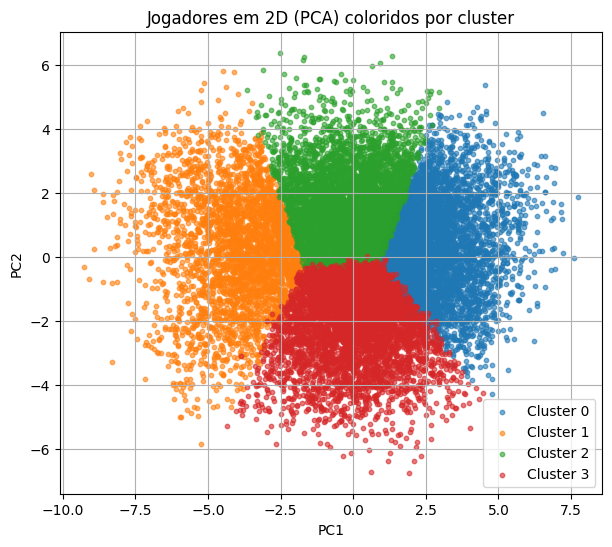

In [13]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

pca = PCA(n_components=2)
coords_2d = pca.fit_transform(X_scaled)

cluster["pc1"] = coords_2d[:, 0]
cluster["pc2"] = coords_2d[:, 1]

plt.figure(figsize=(7,6))
for c in sorted(cluster["cluster"].unique()):
    subset = cluster[cluster["cluster"] == c]
    plt.scatter(subset["pc1"], subset["pc2"], label=f"Cluster {c}", alpha=0.6, s=10)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Jogadores em 2D (PCA) coloridos por cluster")
plt.legend()
plt.grid(True)
plt.show()


### Estatísticas médias por cluster
Geramos uma tabela com a média de cada atributo nas diferentes etiquetas para interpretar as características dominantes de cada segmento.

In [14]:
feature_cols = [
    "pace", "shooting", "passing", "dribbling",
    "defending", "physic",
    "height_cm", "weight_kg", "age",
    "skill_ball_control", "skill_long_passing",
    "movement_acceleration", "movement_sprint_speed",
    "movement_agility", "movement_balance",
    "power_strength", "power_stamina"
]

cluster_means = cluster.groupby("cluster")[feature_cols].mean().round(1)
cluster_means


,pace,shooting,passing,dribbling,defending,physic,height_cm,weight_kg,age,skill_ball_control,skill_long_passing,movement_acceleration,movement_sprint_speed,movement_agility,movement_balance,power_strength,power_stamina
cluster,,,,,,,,,,,,,,,,,
0,77.5,63.9,66.6,72.6,51.1,65.0,174.4,68.4,25.9,72.4,63.9,78.2,76.9,78.0,76.6,62.4,73.4
1,56.4,37.6,47.0,50.2,59.7,69.8,187.3,80.2,25.4,53.8,50.1,55.1,57.4,50.4,52.4,75.7,62.4
2,65.8,55.6,62.2,65.4,60.6,71.8,182.1,76.0,27.5,67.5,63.3,65.3,66.2,65.2,64.8,72.9,72.6
3,70.0,50.5,53.0,60.9,41.6,54.8,177.3,70.1,21.6,60.2,50.4,70.3,69.7,67.6,69.3,54.8,58.7


### Distribuição de posições dentro de cada cluster
Calculamos contagens e proporções por `position_group` para verificar se há clusters dominados por defesas, médios ou avançados.

In [15]:
pos_counts = cluster.groupby(["cluster", "position_group"]).size().unstack(fill_value=0)
pos_props = pos_counts.div(pos_counts.sum(axis=1), axis=0)
pos_props


position_group,ATT,DEF,MID
cluster,,,
0,0.272578,0.205255,0.522167
1,0.107389,0.806512,0.086099
2,0.152372,0.393478,0.454150
3,0.295085,0.249271,0.455643


### Análise de género por cluster
Usamos `crosstab` para obter contagens e proporções de homens e mulheres em cada cluster, avaliando possíveis enviesamentos de género.

In [16]:
# tabela cluster x género
ct = pd.crosstab(cluster["cluster"], cluster["gender"])
print(ct)

# proporções dentro de cada cluster
props = ct.div(ct.sum(axis=1), axis=0)
print(props)


gender     F     M
cluster           
0        896  3976
1         55  3139
2        365  4695
3        307  4495
gender          F         M
cluster                    
0        0.183908  0.816092
1        0.017220  0.982780
2        0.072134  0.927866
3        0.063932  0.936068


### Visualizações PCA segmentadas por cluster e género
As figuras seguintes reforçam a leitura dos clusters no espaço 2D, primeiro distinguindo rótulos e géneros simultaneamente e depois apenas por género para identificar sobreposições.

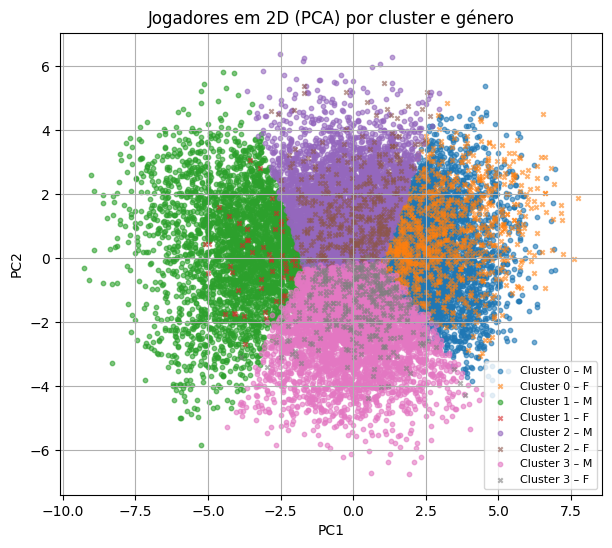

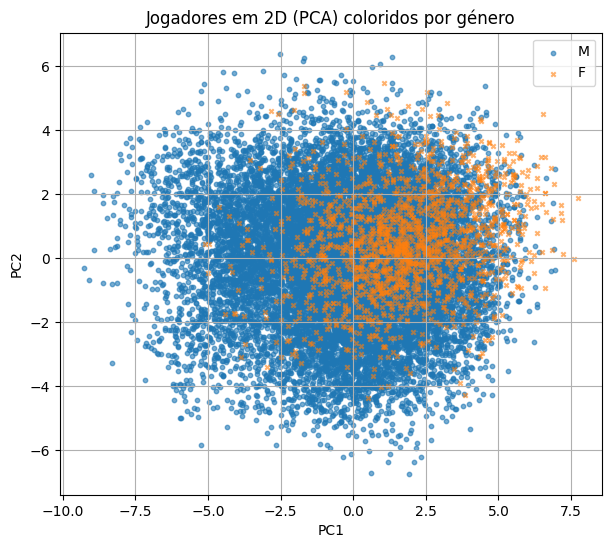

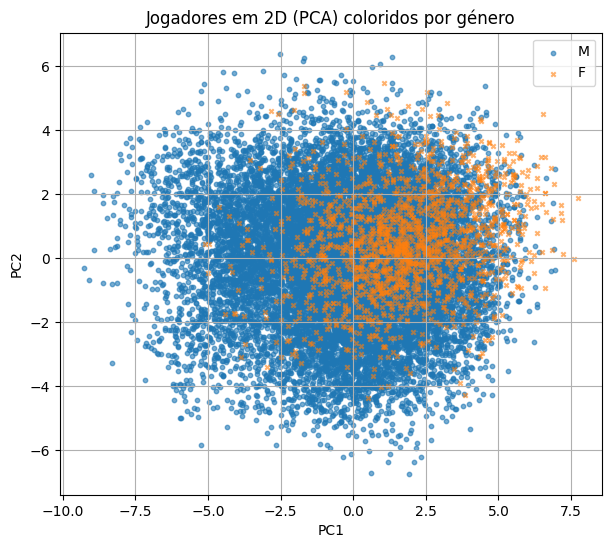

In [17]:
import matplotlib.pyplot as plt

markers = {"M": "o", "F": "x"}  # círculo para M, X para F

plt.figure(figsize=(7, 6))

for c in sorted(cluster["cluster"].unique()):
    for g in ["M", "F"]:
        subset = cluster[(cluster["cluster"] == c) & (cluster["gender"] == g)]
        if subset.empty:
            continue

        plt.scatter(
            subset["pc1"],
            subset["pc2"],
            marker=markers[g],
            alpha=0.6,
            s=10,
            label=f"Cluster {c} – {g}"
        )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Jogadores em 2D (PCA) por cluster e género")
plt.legend(loc="best", fontsize=8)
plt.grid(True)
plt.show()


plt.figure(figsize=(7, 6))

markers = {"M": "o", "F": "x"}

for g in ["M", "F"]:
    subset = cluster[cluster["gender"] == g]
    plt.scatter(
        subset["pc1"],
        subset["pc2"],
        marker=markers[g],
        alpha=0.6,
        s=10,
        label=g
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Jogadores em 2D (PCA) coloridos por género")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(7, 6))

markers = {"M": "o", "F": "x"}

for g in ["M", "F"]:
    subset = cluster[cluster["gender"] == g]
    plt.scatter(
        subset["pc1"],
        subset["pc2"],
        marker=markers[g],
        alpha=0.6,
        s=10,
        label=g
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Jogadores em 2D (PCA) coloridos por género")
plt.legend()
plt.grid(True)
plt.show()


## Conclusão
Os clusters revelam perfis distintos combinando velocidade, técnica e força, permitindo descrever arquétipos de jogadores/as em campo.
As tabelas de género e posição confirmam que os segmentos não são monopolizados por um único grupo, embora alguns apresentem maior concentração de médios ou avançados.
As projeções PCA ajudam a validar a separação entre clusters e evidenciam ligeiras diferenças entre masculino e feminino.
Próximos passos possíveis incluem testar outros algoritmos (e.g., GMM), ajustar `k` com métricas adicionais e gerar relatórios automatizados por equipa ou liga.